# Análisis de eficiencia de algoritmos criptográficos

## Instalación de bibliotecas

In [1]:
pip install cryptography

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
## BIBLIOTECAS RELEVANTES PARA EL DESARROLLO DEL PROYECTO ##
import pandas as pd
import hashlib
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import timeit
import os #importante para las instrucciones de sistema operativo
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes #importante para usar los algoritmos de cifrado simetricos y escoger los modos
from cryptography.hazmat.primitives.ciphers.aead import AESGCM #para el uso de AES-GCM
from cryptography.hazmat.primitives.asymmetric import rsa #Para RSA
from cryptography.hazmat.primitives.asymmetric import padding #Necesario para poder utilizar el modo OAEP de RSA
from cryptography.hazmat.primitives import serialization #Para serializar las llaves de RSA-OAEP
from cryptography.hazmat.primitives import hashes #Para poder utilizar los hashes que requiere RSA-OAEP, y usar SHA-2 y SHA-3
from cryptography.hazmat.primitives.kdf.scrypt import Scrypt #Como el import lo dice, es para el algoritmo Scrypt
from cryptography.hazmat.primitives.asymmetric import ec #Para las curvas elípticas
from cryptography.hazmat.primitives.asymmetric import utils
from cryptography.hazmat.primitives.asymmetric.ed25519 import (Ed25519PrivateKey, Ed25519PublicKey)#Para EdDSA
from sqlalchemy.sql.sqltypes import Time

##Importar vectores de prueba

In [3]:
#Importar los vectores de prueba
!wget -O cipherTestVectors.csv https://raw.githubusercontent.com/salinasromerodaniel/Archivos1stProjectCrypto/main/cipherTestVectors.csv
!wget -O digSignTestVectors.csv https://raw.githubusercontent.com/salinasromerodaniel/Archivos1stProjectCrypto/main/digSignTestVectors.csv
!wget -O hashTestVectors.csv https://raw.githubusercontent.com/salinasromerodaniel/Archivos1stProjectCrypto/main/hashTestVectors.csv

--2023-05-02 01:08:57--  https://raw.githubusercontent.com/salinasromerodaniel/Archivos1stProjectCrypto/main/cipherTestVectors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5433 (5.3K) [text/plain]
Saving to: ‘cipherTestVectors.csv’

cipherTestVectors.c 100%[===================>]   5.31K  --.-KB/s    in 0s      

2023-05-02 01:08:57 (51.6 MB/s) - ‘cipherTestVectors.csv’ saved [5433/5433]

--2023-05-02 01:08:57--  https://raw.githubusercontent.com/salinasromerodaniel/Archivos1stProjectCrypto/main/digSignTestVectors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request 

## Vectores de prueba

### Vectores de cifrado

In [4]:
# Guarda los datos del csv de cifrado en una lista
test_vectors_ChaCha20 = []
test_vectors_AES_ECB  = []
test_vectors_AES_GCM  = []
test_vectors_RSA_OAEP = []

with open("cipherTestVectors.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)

    # First five rows of the CSV are the five ChaCha20 testing vectors
    # [ plain_text   nonce   key ]
    [test_vectors_ChaCha20.append(next(reader)) for i in range(5)]  

    # The next five rows are the five AES-EBC testing vectors
    # [ plain_text   key ]
    [test_vectors_AES_ECB.append(next(reader)) for i in range(5)]

    # The next five rows are the five AES-GCM testing vectors
    # [ plain_text   aad  key nonce  ]
    [test_vectors_AES_GCM.append(next(reader)) for i in range(5)]

    # The next five rows are the five RSA_OAEP testing vectors
    # [ plain_text ]
    [test_vectors_RSA_OAEP.append(next(reader)) for i in range(5)]

In [5]:
# Convierte los datos de una lista de formato hexadecimal a binario
def toHex(sList):
  for i in range(len(sList)):
    for j in range(len(sList[i])):
        sList[i][j] = bytes.fromhex(sList[i][j])
  return sList

toHex(test_vectors_ChaCha20)
toHex(test_vectors_AES_ECB)
toHex(test_vectors_AES_GCM)
toHex(test_vectors_RSA_OAEP)

[[b'\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'],
 [b'\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'],
 [b'\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'],
 [b'\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11

### Vectores de hashing

In [6]:
# Guarda los datos del csv de hashing en una lista
test_vectors_SHA_2  = []
test_vectors_SHA_3  = []
test_vectors_Scrypt = []

with open("hashTestVectors.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) 

    # First five rows of the CSV are the five SHA-2 testing vectors
    [test_vectors_SHA_2.append(next(reader)) for i in range(5)] 

    # The next five rows are the five SHA-3 testing vectors
    [test_vectors_SHA_3.append(next(reader)) for i in range(5)]

    # The next five rows are the five Scrypt testing vectors
    [test_vectors_Scrypt.append(next(reader)) for i in range(5)]

In [7]:
def toBin(sList):
  for i in range(len(sList)):
    for j in range(len(sList[i])):
        sList[i][j] = sList[i][j].encode('utf-8')
  return sList

toBin(test_vectors_SHA_2)
toBin(test_vectors_SHA_3)
toBin(test_vectors_Scrypt)

[[b'', b''],
 [b'abc', b'0123456789'],
 [b'abcdbcdecdefdefgefghfghighijhijkijkljklmklmnlmnomnopnopq',
  b'000000000000000000000000000000000000'],
 [b'abcdefghbcdefghicdefghijdefghijkefghijklfghijklmghijklmnhijklmnoijklmnopjklmnopqklmnopqrlmnopqrsmnopqrstnopqrstu',
  b'abcdefghbcdefghicdefghij'],
 [b'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

### Vectores de firma digital

In [8]:
# Guarda los datos del csv de hashing en una lista
test_vectors_RSA_PSS = []
test_vectors_ECDSA   = []
test_vectors_EDDSA   = []

with open("digSignTestVectors.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) 
    
    # First five rows of the CSV are the five RSA-PSS testing vectors
    [test_vectors_RSA_PSS.append(next(reader)) for i in range(5)] 

    # The next five rows are the five ECDSA testing vectors
    [test_vectors_ECDSA.append(next(reader)) for i in range(5)]

    # The next five rows are the five EDDSA testing vectors
    [test_vectors_EDDSA.append(next(reader)) for i in range(5)]

In [9]:
toBin(test_vectors_RSA_PSS)
toBin(test_vectors_ECDSA)
toBin(test_vectors_EDDSA)

[[b'3b46736d559bd4e0c2c1b2553a33ad3c6cf23cac998d3d0c0e8fa4b19bca06f2f386db2dcff9dca4f40ad8f561ffc308b46c5f31a7735b5fa7e0f9e6cb512e63d7eea05538d66a75cd0d4234b5ccf6c1715ccaaf9cdc0a2228135f716ee9bdee7fc13ec27a03a6d11c5c5b3685f51900b1337153bc6c4e8f52920c33fa37f4e7'],
 [b'd2bcb53b044b3e2e4b61ba2f91c0995fb83a6a97525e66441a3b489d9594238bc740bdeea0f718a769c977e2de003877b5d7dc25b182ae533db33e78f2c3ff0645f2137abc137d4e7d93ccf24f60b18a820bc07c7b4b5fe08b4f9e7d21b256c18f3b9d49acc4f93e2ce6f3754c7807757d2e1176042612cb32fc3f4f70700e25'],
 [b'd5431e6b16fdae31481742bd394758beb8e24f31947e19b7ea7b458521882270c1f43192aa050f4485145af8f3f9c5142d68b85018d2ec9cb7a37ba12ed23e73b95fd680fba3c61265e9f5a0a027d70fad0c8aa08a3cbfbe99018d0045386173e5fae225faebe0cef5dd45910f400a86c2be4e15252a16de4120a267be2b594d'],
 [b'85662b697550e4915c29e338b624b912845d6d1a920d9e4c1604dd47d692bc7c0ffb95ae614e852bebaf1573758ad01c713cac0b476e2f121745a3cfeeffb2441ff6abfb9bbeb98aa634ca6ff541947dcc9927659d44f95c5ff9170fdc3c86473cb601ba31b4

## Algoritmos de cifrado

### ChaCha20

In [10]:
# Chacha20

def get_cipher_ChaCha20(nonce16, key32):
  return Cipher(algorithms.ChaCha20(key32,nonce16), mode=None)

### AES-EBC

In [11]:
# AES-ECB (Electronic CodeBook) 

def get_cipher_AES_ECB(key32):
  return Cipher(algorithms.AES(key32), modes.ECB())

### AES-GCM

In [12]:
# AES-GCM (Galois Counter Mode) 

def get_cipher_AES_GCM(key32):
  return AESGCM(key32)

### RSA-OAEP

In [13]:
# RSA-OAEP (Optimal Asymmetric Encryption Padding)

#Generación de llaves para RSA-OAEP  (¿los pem vayan dentro de la función?)
private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
public_key = private_key.public_key()
private_pem = private_key.private_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PrivateFormat.PKCS8, 
    encryption_algorithm=serialization.NoEncryption())
public_pem = public_key.public_bytes(
    encoding=serialization.Encoding.PEM, 
    format=serialization.PublicFormat.SubjectPublicKeyInfo)

### Temporizar cifrados

In [14]:
tiempos_cifrado_df = pd.DataFrame(
  columns=['ChaCha20', 'AES-ECB', 'AES-GCM', 'RSA-OAEP']
)

ChaCha20_ciphers = []
AES_ECB_ciphers = []
AES_GCM_ciphers = []

ChaCha20_ciphertexts = []
AES_ECB_ciphertexts = []
AES_GCM_ciphertexts = []
RSA_OAEP_ciphertexts = []

# Agregar filas vacías al DataFrame
for i in range(500):
  tiempos_cifrado_df.loc[i] = [None, None, None, None]

for i in range(5):
  ChaCha20_ciphers.append(
    get_cipher_ChaCha20(test_vectors_ChaCha20[i][1], test_vectors_ChaCha20[i][2])
  )
  ChaCha20_encryptor = ChaCha20_ciphers[i].encryptor()
  ChaCha20_ciphertexts.append(
    ChaCha20_encryptor.update(test_vectors_ChaCha20[i][0])
  )

  AES_ECB_ciphers.append(
    get_cipher_AES_ECB(test_vectors_AES_ECB[i][1])
  )
  AES_ECB_encryptor = AES_ECB_ciphers[i].encryptor()
  AES_ECB_ciphertexts.append(
     AES_ECB_encryptor.update(test_vectors_AES_ECB[i][0]) 
  )

  AES_GCM_ciphers.append(get_cipher_AES_GCM(test_vectors_AES_GCM[i][2]))
  AES_GCM_ciphertexts.append(
    AES_GCM_ciphers[i].encrypt(
        test_vectors_AES_GCM[i][3],test_vectors_AES_GCM[i][0], test_vectors_AES_GCM[i][1])
  )

  RSA_OAEP_ciphertexts.append(
    public_key.encrypt(
      test_vectors_RSA_OAEP[i][0], 
      padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), 
                   algorithm=hashes.SHA256(), label=None)) 
  )

  for j in range(100):

    iter = 100 * i + j

    ChaCha20_time = timeit.timeit(
      lambda: ChaCha20_encryptor.update(test_vectors_ChaCha20[i][0]), number=1
    )
    tiempos_cifrado_df.loc[iter,'ChaCha20'] = ChaCha20_time

    AES_ECB_time = timeit.timeit(
      lambda: AES_ECB_encryptor.update(test_vectors_AES_ECB[i][0]), number=1
    )
    tiempos_cifrado_df.loc[iter, 'AES-ECB'] = AES_ECB_time

    AES_GCM_time = timeit.timeit(
      lambda: AES_GCM_ciphers[i].encrypt(
        test_vectors_AES_GCM[i][3],test_vectors_AES_GCM[i][0], test_vectors_AES_GCM[i][1]),
        number=1
    )
    tiempos_cifrado_df.loc[iter, 'AES-GCM'] = AES_GCM_time
    
    RSA_OAEP_time = timeit.timeit(
      lambda: public_key.encrypt(
        test_vectors_RSA_OAEP[i][0], 
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), 
                   algorithm=hashes.SHA256(), label=None)),
        number=1
    )
    tiempos_cifrado_df.loc[iter, 'RSA-OAEP'] = RSA_OAEP_time

### Análisis estadístico descriptivo de los algoritmos de cifrado

In [15]:
#Definición de Funciones
def toNumeric(dfFull, dfSplit, cont, axis):
  dfFull['ChaCha20'] = pd.to_numeric(dfSplit['ChaCha20'])
  dfFull['AES-ECB'] = pd.to_numeric(dfSplit['AES-ECB'])
  dfFull['AES-GCM'] = pd.to_numeric(dfSplit['AES-GCM'])
  dfFull['RSA-OAEP'] = pd.to_numeric(dfSplit['RSA-OAEP'])
  dfFull.boxplot(ax=axis[cont])
  axis[cont].set_title('Vector de prueba de ' + str((cont+1)*256) + ' bits')

def removeOutliers(dfSplit):
  for columna in dfSplit.columns:
    Q1 = dfSplit[columna].quantile(0.30)
    Q3 = dfSplit[columna].quantile(0.60)
    dfClean = dfSplit[(dfSplit[columna] > Q1) & (dfSplit[columna] < Q3)]
  return dfClean

#Convertimos el DataFrame en un array numpy
array = tiempos_cifrado_df.to_numpy()

#Dividimos el DataFrame en 5 DataFrames por vector de prueba
dataframes = np.array_split(array, 5)
df1 = pd.DataFrame(dataframes[0], columns=tiempos_cifrado_df.columns)
df2 = pd.DataFrame(dataframes[1], columns=tiempos_cifrado_df.columns)
df3 = pd.DataFrame(dataframes[2], columns=tiempos_cifrado_df.columns)
df4 = pd.DataFrame(dataframes[3], columns=tiempos_cifrado_df.columns)
df5 = pd.DataFrame(dataframes[4], columns=tiempos_cifrado_df.columns)

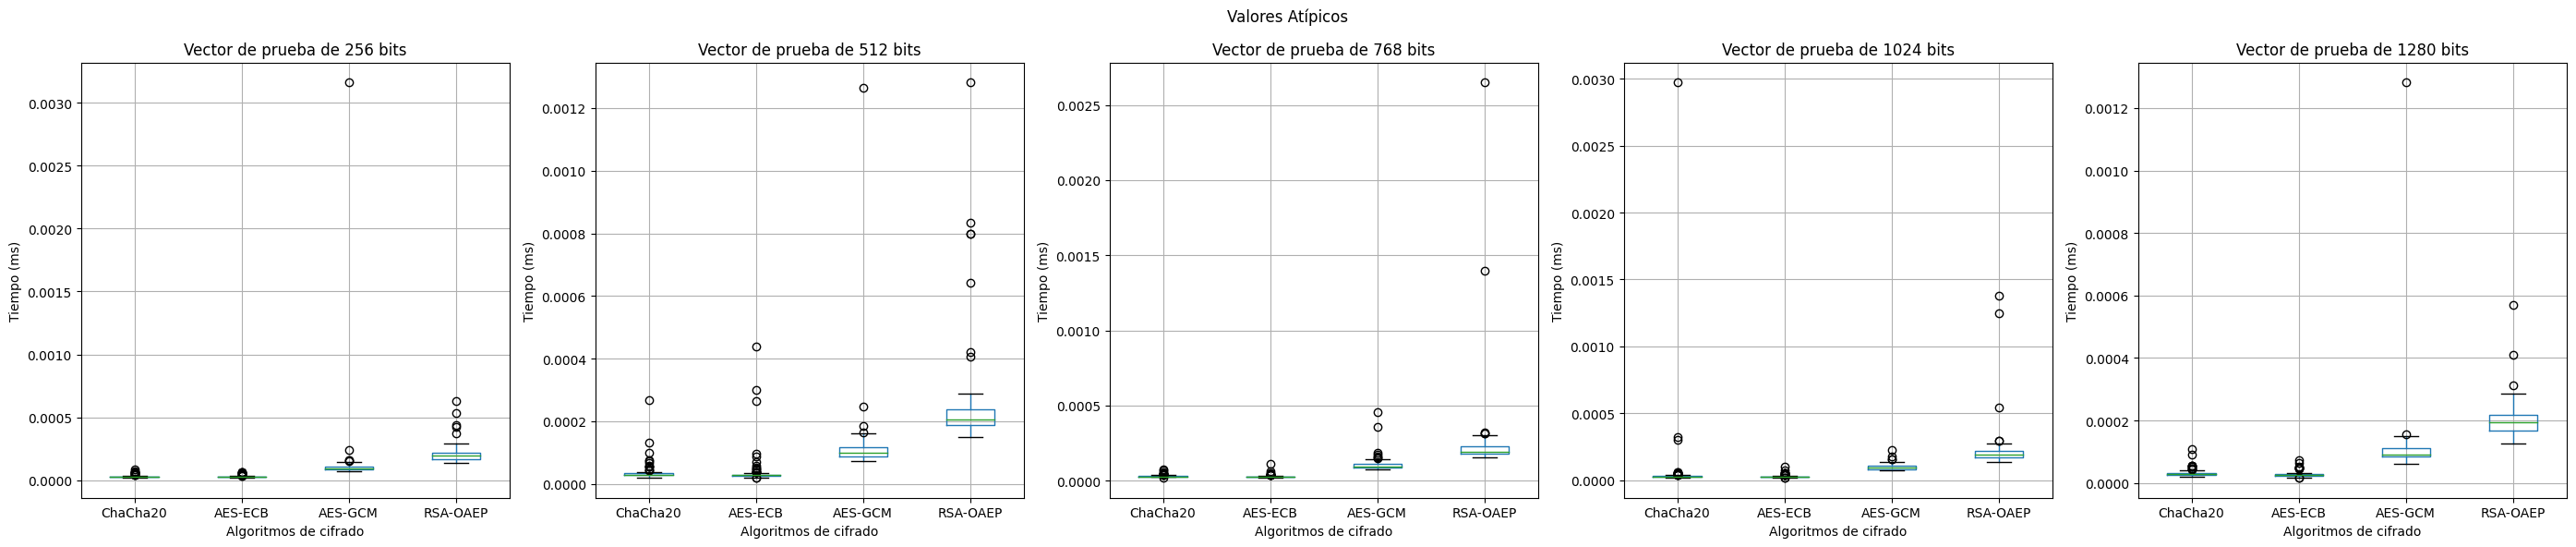

In [16]:
#Observamos los valores atípicos
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 6))

toNumeric(tiempos_cifrado_df, df1, 0, axs)
toNumeric(tiempos_cifrado_df, df2, 1, axs)
toNumeric(tiempos_cifrado_df, df3, 2, axs)
toNumeric(tiempos_cifrado_df, df4, 3, axs)
toNumeric(tiempos_cifrado_df, df5, 4, axs)


# Establecer los títulos de los ejes
for ax in axs.flat:
    ax.set_xlabel('Algoritmos de cifrado')
    ax.set_ylabel('Tiempo (ms)')

plt.suptitle('Valores Atípicos')

# Mostrar la figura
plt.tight_layout()
plt.show()

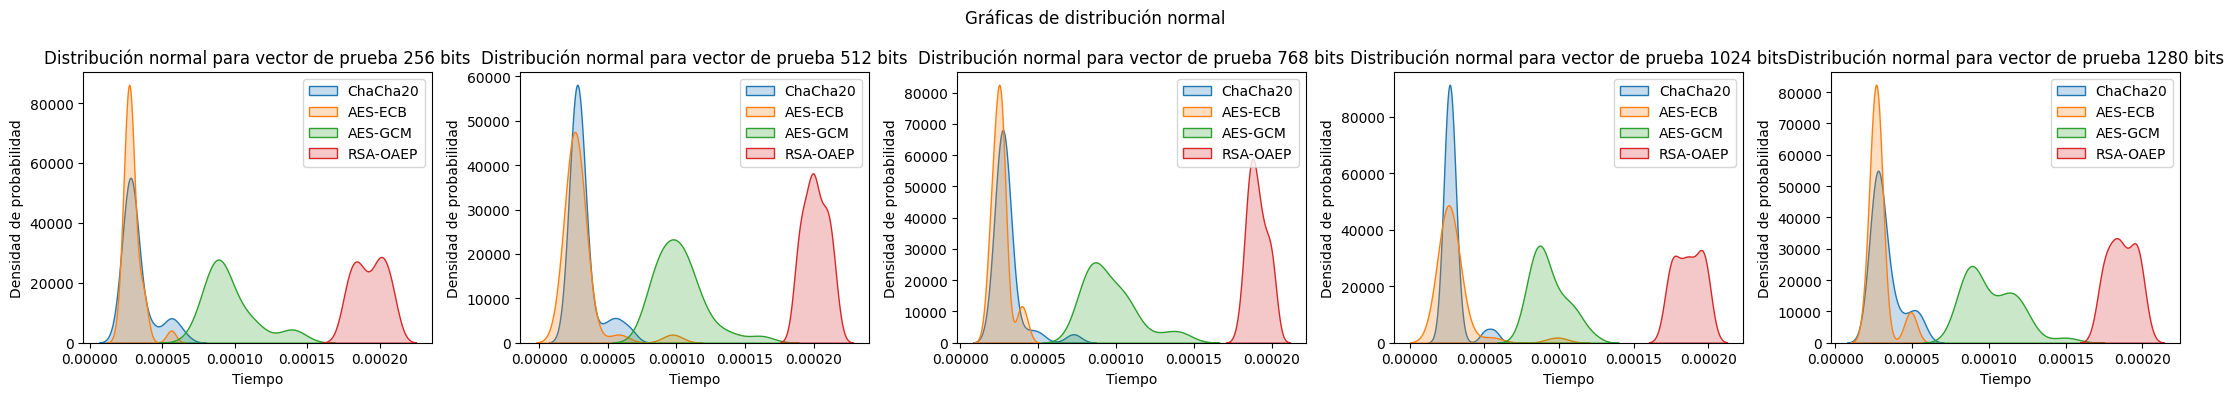

In [17]:
#Quitamos valores atípicos por columna en cada DataFrame
dfa1 = removeOutliers(df1)
dfa2 = removeOutliers(df2)
dfa3 = removeOutliers(df3)
dfa4 = removeOutliers(df4)
dfa5 = removeOutliers(df5)

#Declarar la imagen de gráficas
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))

for col in dfa1.columns:
    sns.kdeplot(dfa1[col], fill=True, label=col, ax=axs[0])

axs[0].set_title('Distribución normal para vector de prueba 256 bits')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()


for col in dfa2.columns:
    sns.kdeplot(dfa2[col], fill=True, label=col, ax=axs[1])

axs[1].set_title('Distribución normal para vector de prueba 512 bits')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()


for col in dfa3.columns:
    sns.kdeplot(dfa3[col], fill=True, label=col, ax=axs[2])

axs[2].set_title('Distribución normal para vector de prueba 768 bits')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Densidad de probabilidad')
axs[2].legend()


for col in dfa4.columns:
    sns.kdeplot(dfa4[col], fill=True, label=col, ax=axs[3])

axs[3].set_title('Distribución normal para vector de prueba 1024 bits')
axs[3].set_xlabel('Tiempo')
axs[3].set_ylabel('Densidad de probabilidad')
axs[3].legend()

for col in dfa5.columns:
    sns.kdeplot(dfa5[col], fill=True, label=col, ax=axs[4])

axs[4].set_title('Distribución normal para vector de prueba 1280 bits')
axs[4].set_xlabel('Tiempo')
axs[4].set_ylabel('Densidad de probabilidad')
axs[4].legend()

plt.suptitle('Gráficas de distribución normal')

fig.tight_layout()
plt.show()


In [18]:
#Calculamos las medias y la desviación estándar
media1 = dfa1.mean()
media2 = dfa2.mean()
media3 = dfa3.mean()
media4 = dfa4.mean()
media5 = dfa5.mean()
std1 = dfa1.std()
std2 = dfa2.std()
std3 = dfa3.std()
std4 = dfa4.std()
std5 = dfa5.std()

#DataFrame de medias 256, 512, 768, 1024 y 1280
data = {'256 bits': media1,
        '512 bits': media2,
        '768 bits': media3,
        '1024 bits': media4,
        '1280 bits': media5}
Medias = pd.DataFrame(data)

#DataFrame de desviación estándar 256, 512, 768, 1024 y 1280
data = {'256 bits': std1,
        '512 bits': std2,
        '768 bits': std3,
        '1024 bits': std4,
        '1280 bits': std5}
Desviacion = pd.DataFrame(data)

#Imprimir los DataFrame de medias y desviación
print("Tabla de Medias\n")
print(Medias)
print("\n")
print("Tabla de Desviación estándar\n")
print(Desviacion)

Tabla de Medias

          256 bits  512 bits  768 bits  1024 bits  1280 bits
ChaCha20  0.000033  0.000032  0.000030   0.000029   0.000033
AES-ECB   0.000029  0.000030  0.000026   0.000030   0.000029
AES-GCM   0.000097  0.000103  0.000097   0.000093   0.000102
RSA-OAEP  0.000193  0.000201  0.000191   0.000187   0.000187


Tabla de Desviación estándar

          256 bits  512 bits  768 bits  1024 bits  1280 bits
ChaCha20  0.000011  0.000010  0.000010   0.000007   0.000009
AES-ECB   0.000006  0.000014  0.000006   0.000014   0.000007
AES-GCM   0.000018  0.000018  0.000017   0.000012   0.000017
RSA-OAEP  0.000011  0.000008  0.000006   0.000009   0.000009


### Temporizar descifrado

In [19]:
tiempos_decifrado_df = pd.DataFrame(
  columns=['ChaCha20', 'AES-ECB', 'AES-GCM', 'RSA-OAEP']
)

for i in range(500):
  tiempos_decifrado_df.loc[i] = [None, None, None, None]

for i in range(5):
  ChaCha20_decryptor = ChaCha20_ciphers[i].decryptor()
  AES_ECB_decryptor = AES_ECB_ciphers[i].decryptor()

  for j in range(100):
    iter = 100 * i + j
    ChaCha20_time = timeit.timeit(
      lambda: ChaCha20_decryptor.update(ChaCha20_ciphertexts[i]), number=1
    )
    tiempos_decifrado_df.loc[iter,'ChaCha20'] = ChaCha20_time

    AES_ECB_time = timeit.timeit(
      lambda: AES_ECB_decryptor.update(AES_ECB_ciphertexts[i]), number=1
    )
    tiempos_decifrado_df.loc[iter, 'AES-ECB'] = AES_ECB_time

    AES_GCM_time = timeit.timeit(
      lambda: AES_GCM_ciphers[i].decrypt(
        test_vectors_AES_GCM[i][3], AES_GCM_ciphertexts[i],test_vectors_AES_GCM[i][1]),
        number=1
    )
    tiempos_decifrado_df.loc[iter, 'AES-GCM'] = AES_GCM_time
    
    RSA_OAEP_time = timeit.timeit(
      lambda: private_key.decrypt(
        RSA_OAEP_ciphertexts[i], 
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), 
                   algorithm=hashes.SHA256(), label=None)),
        number=1
    )
    tiempos_decifrado_df.loc[iter, 'RSA-OAEP'] = RSA_OAEP_time

###Análisis estadístico descriptivo de los algoritmos de descifrado

In [20]:
#Definición de Funciones
def toNumeric(dfFull, dfSplit, cont, axis):
  dfFull['ChaCha20'] = pd.to_numeric(dfSplit['ChaCha20'])
  dfFull['AES-ECB'] = pd.to_numeric(dfSplit['AES-ECB'])
  dfFull['AES-GCM'] = pd.to_numeric(dfSplit['AES-GCM'])
  dfFull['RSA-OAEP'] = pd.to_numeric(dfSplit['RSA-OAEP'])
  dfFull.boxplot(ax=axis[cont])
  axis[cont].set_title('Vector de prueba de ' + str((cont+1)*256) + ' bits')

def removeOutliers(dfSplit):
  for columna in dfSplit.columns:
    Q1 = dfSplit[columna].quantile(0.30)
    Q3 = dfSplit[columna].quantile(0.60)
    dfClean = dfSplit[(dfSplit[columna] > Q1) & (dfSplit[columna] < Q3)]
  return dfClean

#Convertimos el DataFrame en un array numpy
array = tiempos_decifrado_df.to_numpy()

#Dividimos el DataFrame en 5 DataFrames por vector de prueba
dataframes = np.array_split(array, 5)
df1 = pd.DataFrame(dataframes[0], columns=tiempos_decifrado_df.columns)
df2 = pd.DataFrame(dataframes[1], columns=tiempos_decifrado_df.columns)
df3 = pd.DataFrame(dataframes[2], columns=tiempos_decifrado_df.columns)
df4 = pd.DataFrame(dataframes[3], columns=tiempos_decifrado_df.columns)
df5 = pd.DataFrame(dataframes[4], columns=tiempos_decifrado_df.columns)

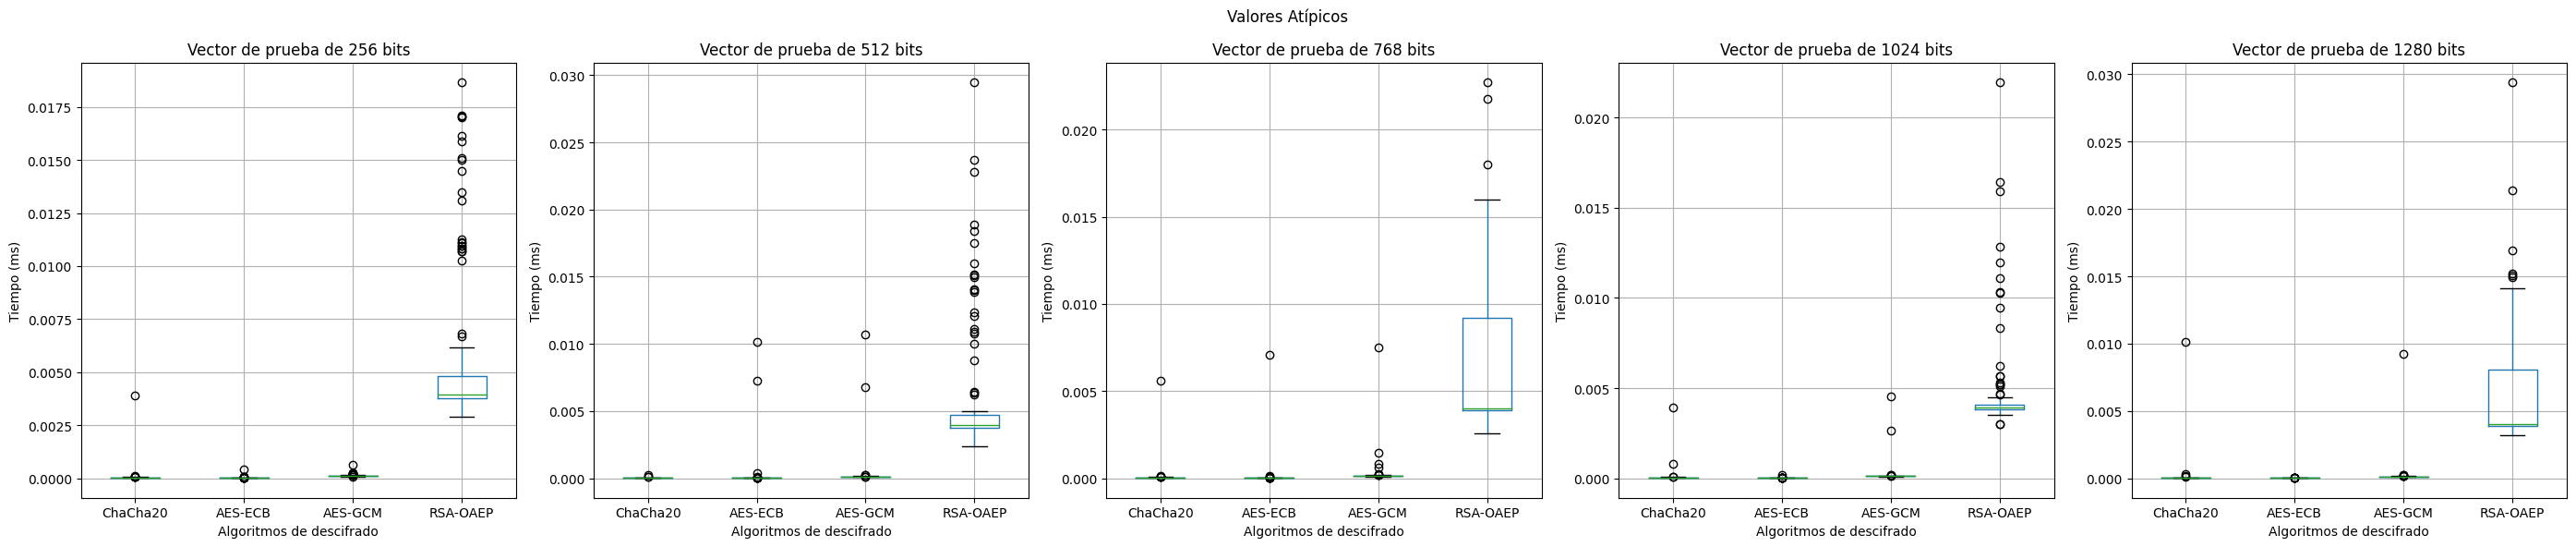

In [21]:
#Observamos los valores atípicos
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 6))

toNumeric(tiempos_decifrado_df, df1, 0, axs)
toNumeric(tiempos_decifrado_df, df2, 1, axs)
toNumeric(tiempos_decifrado_df, df3, 2, axs)
toNumeric(tiempos_decifrado_df, df4, 3, axs)
toNumeric(tiempos_decifrado_df, df5, 4, axs)


# Establecer los títulos de los ejes
for ax in axs.flat:
    ax.set_xlabel('Algoritmos de descifrado')
    ax.set_ylabel('Tiempo (ms)')

plt.suptitle('Valores Atípicos')

# Mostrar la figura
plt.tight_layout()
plt.show()

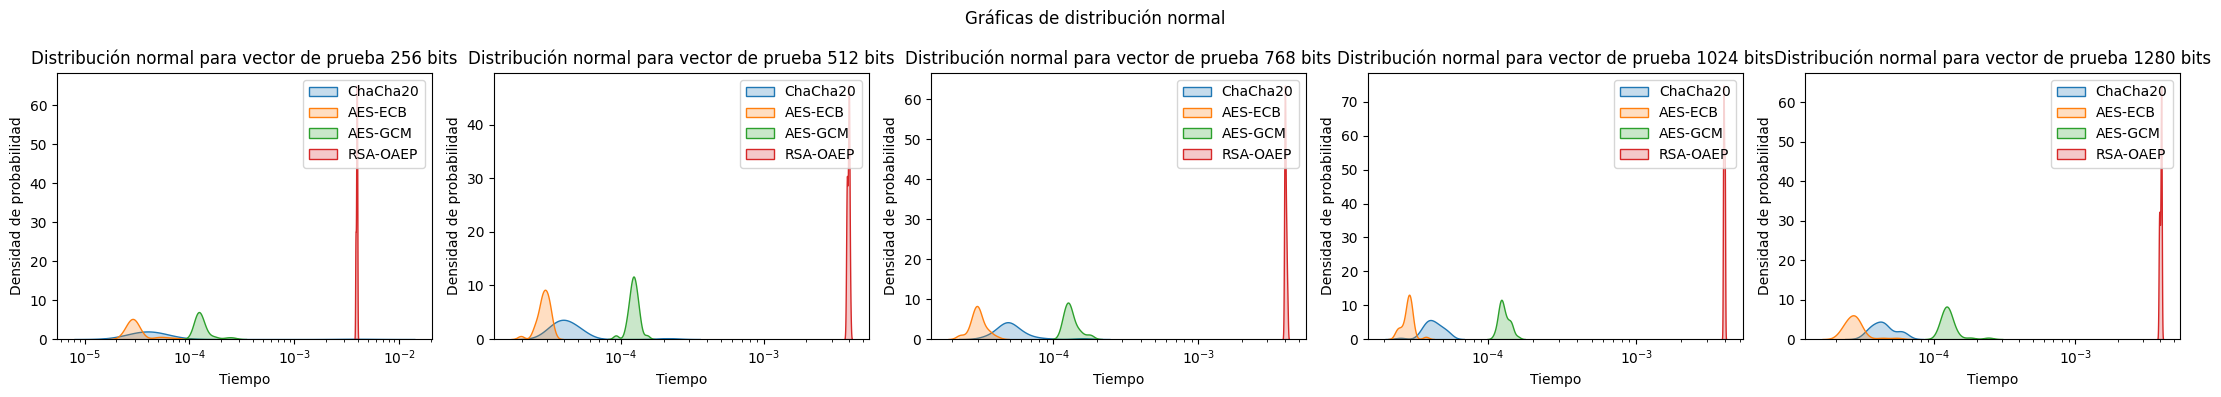

In [22]:
#Quitamos valores atípicos por columna en cada DataFrame
dfa1 = removeOutliers(df1)
dfa2 = removeOutliers(df2)
dfa3 = removeOutliers(df3)
dfa4 = removeOutliers(df4)
dfa5 = removeOutliers(df5)

#Declarar la imagen de gráficas
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))

for col in dfa1.columns:
    sns.kdeplot(dfa1[col], log_scale=True, fill=True, label=col, ax=axs[0])

axs[0].set_title('Distribución normal para vector de prueba 256 bits')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()


for col in dfa2.columns:
    sns.kdeplot(dfa2[col], log_scale=True, fill=True, label=col, ax=axs[1])

axs[1].set_title('Distribución normal para vector de prueba 512 bits')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()


for col in dfa3.columns:
    sns.kdeplot(dfa3[col], log_scale=True, fill=True, label=col, ax=axs[2])

axs[2].set_title('Distribución normal para vector de prueba 768 bits')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Densidad de probabilidad')
axs[2].legend()


for col in dfa4.columns:
    sns.kdeplot(dfa4[col], log_scale=True, fill=True, label=col, ax=axs[3])

axs[3].set_title('Distribución normal para vector de prueba 1024 bits')
axs[3].set_xlabel('Tiempo')
axs[3].set_ylabel('Densidad de probabilidad')
axs[3].legend()

for col in dfa5.columns:
    sns.kdeplot(dfa5[col], log_scale=True, fill=True, label=col, ax=axs[4])

axs[4].set_title('Distribución normal para vector de prueba 1280 bits')
axs[4].set_xlabel('Tiempo')
axs[4].set_ylabel('Densidad de probabilidad')
axs[4].legend()

plt.suptitle('Gráficas de distribución normal')

fig.tight_layout()
plt.show()

In [23]:
#Calculamos las medias y la desviación estándar
media1 = dfa1.mean()
media2 = dfa2.mean()
media3 = dfa3.mean()
media4 = dfa4.mean()
media5 = dfa5.mean()
std1 = dfa1.std()
std2 = dfa2.std()
std3 = dfa3.std()
std4 = dfa4.std()
std5 = dfa5.std()

#DataFrame de medias 256, 512, 768, 1024 y 1280
data = {'256 bits': media1,
        '512 bits': media2,
        '768 bits': media3,
        '1024 bits': media4,
        '1280 bits': media5}
Medias = pd.DataFrame(data)

#DataFrame de desviación estándar 256, 512, 768, 1024 y 1280
data = {'256 bits': std1,
        '512 bits': std2,
        '768 bits': std3,
        '1024 bits': std4,
        '1280 bits': std5}
Desviacion = pd.DataFrame(data)

#Imprimir los DataFrame de medias y desviación
print("Tabla de Medias\n")
print(Medias)
print("\n")
print("Tabla de Desviación estándar\n")
print(Desviacion)

Tabla de Medias

          256 bits  512 bits  768 bits  1024 bits  1280 bits
ChaCha20  0.000169  0.000046  0.000054   0.000043   0.000044
AES-ECB   0.000033  0.000029  0.000030   0.000029   0.000028
AES-GCM   0.000135  0.000122  0.000133   0.000129   0.000129
RSA-OAEP  0.003912  0.003924  0.003995   0.003904   0.004011


Tabla de Desviación estándar

          256 bits  512 bits  768 bits  1024 bits  1280 bits
ChaCha20  0.000704  0.000032  0.000022   0.000006   0.000009
AES-ECB   0.000011  0.000003  0.000004   0.000003   0.000006
AES-GCM   0.000033  0.000010  0.000017   0.000011   0.000025
RSA-OAEP  0.000050  0.000071  0.000059   0.000040   0.000061


## Algoritmos de hashing

### SHA-2

In [24]:
# SHA-2 (512 bits)

def Time_SHA2(message):
  digest = hashes.Hash(hashes.SHA512())
  digest.update(message)
  hash = digest.finalize()

### SHA-3

In [25]:
# SHA-3 (512 bits)

def Time_SHA3(message):
  digest = hashes.Hash(hashes.SHA3_512())
  digest.update(message)
  hash = digest.finalize()

### Scrypt

In [26]:
# Scrypt (Output size 32 bits)

def Time_Scrypt(message, salt):
  kdf = Scrypt(salt=salt, length=32, n=2 ** 14, r=8, p=1)
  key = kdf.derive(message)

### Temporizar hashing

In [27]:
## ALGORITMOS DE HASHING: SHA-2, SHA-3, Scrypt

# Creación del DataFrame
tiempos_hashing_df = pd.DataFrame(columns=['SHA-2', 'SHA-3', 'Scrypt'])

# Agregar filas vacías al DataFrame
for i in range(500):
  tiempos_hashing_df.loc[i] = [None, None, None]

# Agregar tiempos a las columnas correspondientes
for i in range(5):
  for j in range(100):
    iter = i * 100 + j
    tiempo = timeit.timeit(
        lambda: Time_SHA2(test_vectors_SHA_2[i][0]), number=1)
    tiempos_hashing_df.loc[iter, 'SHA-2'] = tiempo

    tiempo = timeit.timeit(
        lambda: Time_SHA3(test_vectors_SHA_3[i][0]), number=1)
    tiempos_hashing_df.loc[iter, 'SHA-3'] = tiempo

    tiempo = timeit.timeit(
        lambda: Time_Scrypt(test_vectors_Scrypt[i][0], 
                            test_vectors_Scrypt[i][1]),
        number=1)
    tiempos_hashing_df.loc[iter, 'Scrypt'] = tiempo


###Análisis estadístico descriptivo de los algoritmos de hashing

In [28]:
#Definición de Funciones
def toNumeric(dfFull, dfSplit, cont, axis):
  dfFull['SHA-2'] = pd.to_numeric(dfSplit['SHA-2'])
  dfFull['SHA-3'] = pd.to_numeric(dfSplit['SHA-3'])
  dfFull['Scrypt'] = pd.to_numeric(dfSplit['Scrypt'])
  dfFull.boxplot(ax=axis[cont])
  axis[cont].set_title('Vector de prueba de ' + str((cont+1)*256) + ' bits')

def removeOutliers(dfSplit):
  for columna in dfSplit.columns:
    Q1 = dfSplit[columna].quantile(0.30)
    Q3 = dfSplit[columna].quantile(0.60)
    dfClean = dfSplit[(dfSplit[columna] > Q1) & (dfSplit[columna] < Q3)]
  return dfClean

#Convertimos el DataFrame en un array numpy
array = tiempos_hashing_df.to_numpy()

#Dividimos el DataFrame en 5 DataFrames por vector de prueba
dataframes = np.array_split(array, 5)
df1 = pd.DataFrame(dataframes[0], columns=tiempos_hashing_df.columns)
df2 = pd.DataFrame(dataframes[1], columns=tiempos_hashing_df.columns)
df3 = pd.DataFrame(dataframes[2], columns=tiempos_hashing_df.columns)
df4 = pd.DataFrame(dataframes[3], columns=tiempos_hashing_df.columns)
df5 = pd.DataFrame(dataframes[4], columns=tiempos_hashing_df.columns)

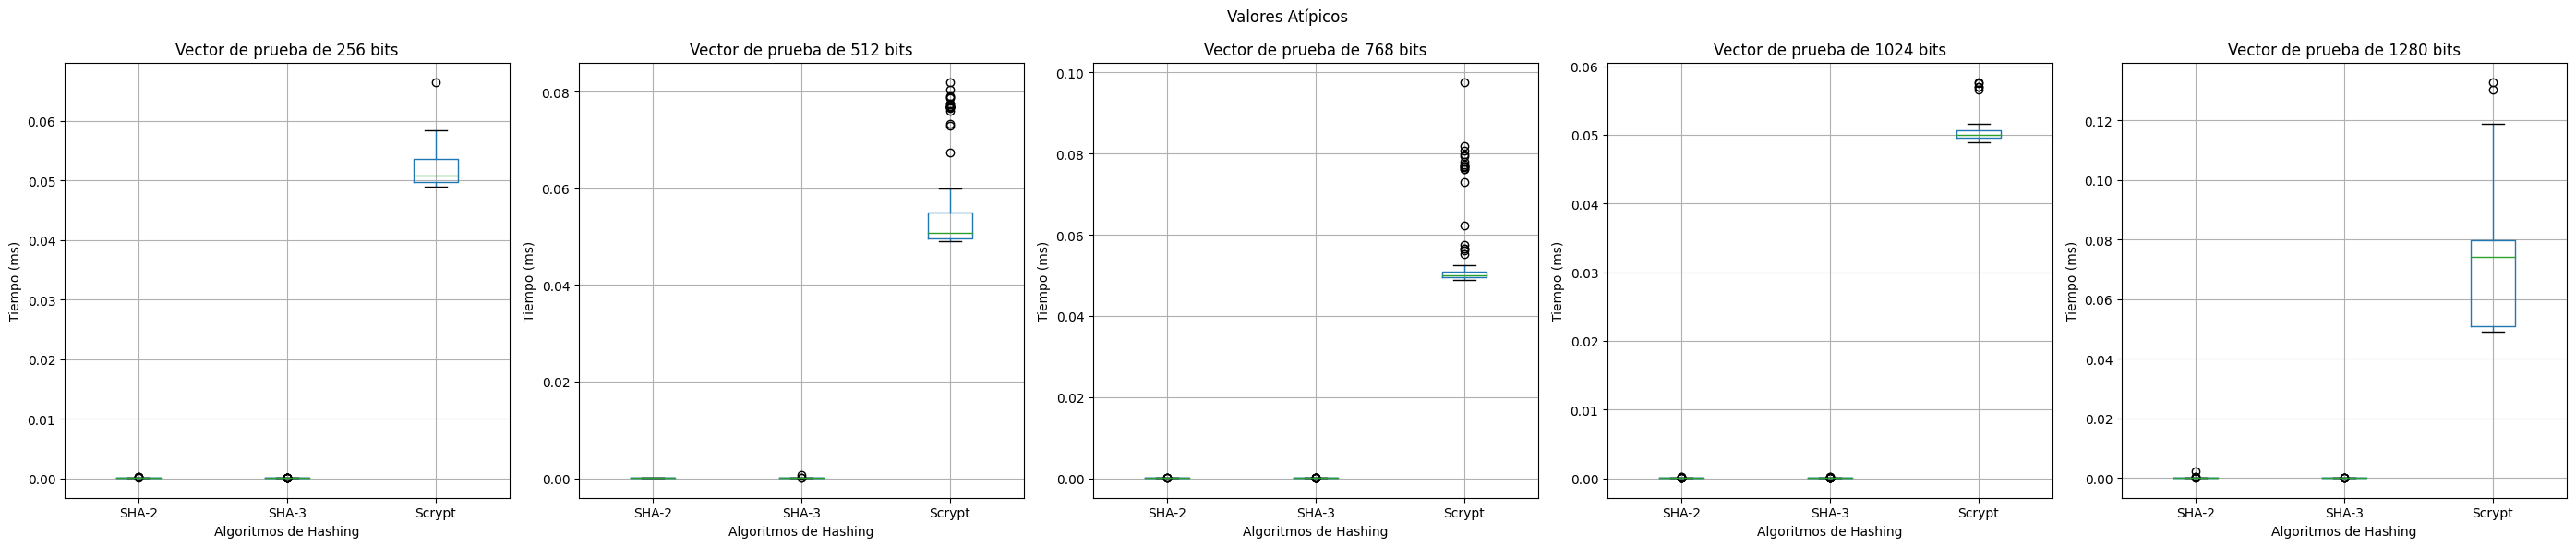

In [29]:
#Observamos los valores atípicos
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 6))

toNumeric(tiempos_hashing_df, df1, 0, axs)
toNumeric(tiempos_hashing_df, df2, 1, axs)
toNumeric(tiempos_hashing_df, df3, 2, axs)
toNumeric(tiempos_hashing_df, df4, 3, axs)
toNumeric(tiempos_hashing_df, df5, 4, axs)


# Establecer los títulos de los ejes
for ax in axs.flat:
    ax.set_xlabel('Algoritmos de Hashing')
    ax.set_ylabel('Tiempo (ms)')

plt.suptitle('Valores Atípicos')

# Mostrar la figura
plt.tight_layout()
plt.show()

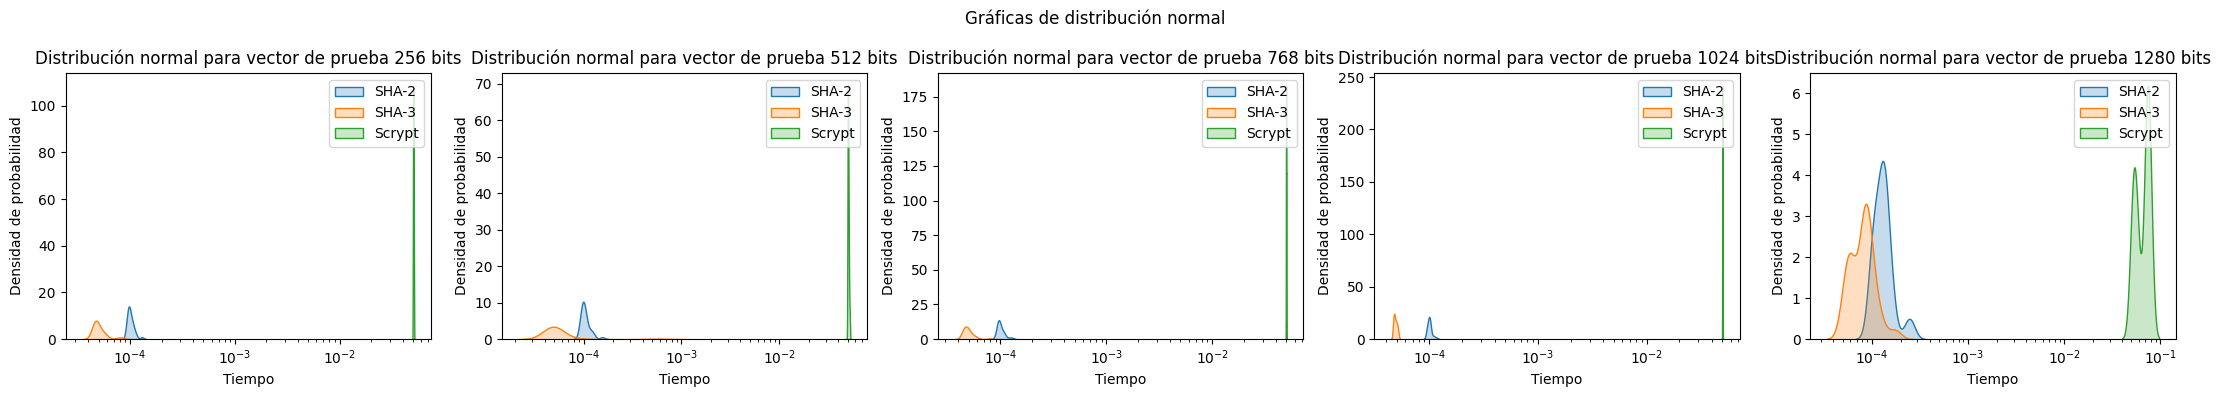

In [30]:
#Quitamos valores atípicos por columna en cada DataFrame
dfa1 = removeOutliers(df1)
dfa2 = removeOutliers(df2)
dfa3 = removeOutliers(df3)
dfa4 = removeOutliers(df4)
dfa5 = removeOutliers(df5)

#Declarar la imagen de gráficas
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))

for col in dfa1.columns:
    sns.kdeplot(dfa1[col], log_scale=True, fill=True, label=col, ax=axs[0])

axs[0].set_title('Distribución normal para vector de prueba 256 bits')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()


for col in dfa2.columns:
    sns.kdeplot(dfa2[col], log_scale=True, fill=True, label=col, ax=axs[1])

axs[1].set_title('Distribución normal para vector de prueba 512 bits')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()


for col in dfa3.columns:
    sns.kdeplot(dfa3[col], log_scale=True, fill=True, label=col, ax=axs[2])

axs[2].set_title('Distribución normal para vector de prueba 768 bits')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Densidad de probabilidad')
axs[2].legend()


for col in dfa4.columns:
    sns.kdeplot(dfa4[col], log_scale=True, fill=True, label=col, ax=axs[3])

axs[3].set_title('Distribución normal para vector de prueba 1024 bits')
axs[3].set_xlabel('Tiempo')
axs[3].set_ylabel('Densidad de probabilidad')
axs[3].legend()

for col in dfa5.columns:
    sns.kdeplot(dfa5[col], log_scale=True, fill=True, label=col, ax=axs[4])

axs[4].set_title('Distribución normal para vector de prueba 1280 bits')
axs[4].set_xlabel('Tiempo')
axs[4].set_ylabel('Densidad de probabilidad')
axs[4].legend()

plt.suptitle('Gráficas de distribución normal')

fig.tight_layout()
plt.show()

In [31]:
#Calculamos las medias y la desviación estándar
media1 = dfa1.mean()
media2 = dfa2.mean()
media3 = dfa3.mean()
media4 = dfa4.mean()
media5 = dfa5.mean()
std1 = dfa1.std()
std2 = dfa2.std()
std3 = dfa3.std()
std4 = dfa4.std()
std5 = dfa5.std()

#DataFrame de medias 256, 512, 768, 1024 y 1280
data = {'256 bits': media1,
        '512 bits': media2,
        '768 bits': media3,
        '1024 bits': media4,
        '1280 bits': media5}
Medias = pd.DataFrame(data)

#DataFrame de desviación estándar 256, 512, 768, 1024 y 1280
data = {'256 bits': std1,
        '512 bits': std2,
        '768 bits': std3,
        '1024 bits': std4,
        '1280 bits': std5}
Desviacion = pd.DataFrame(data)

#Imprimir los DataFrame de medias y desviación
print("Tabla de Medias\n")
print(Medias)
print("\n")
print("Tabla de Desviación estándar\n")
print(Desviacion)

Tabla de Medias

        256 bits  512 bits  768 bits  1024 bits  1280 bits
SHA-2   0.000101  0.000105  0.000101   0.000101   0.000135
SHA-3   0.000051  0.000069  0.000050   0.000049   0.000083
Scrypt  0.050565  0.050660  0.049866   0.049946   0.065456


Tabla de Desviación estándar

        256 bits  512 bits  768 bits  1024 bits  1280 bits
SHA-2   0.000008  0.000013  0.000009   0.000005   0.000036
SHA-3   0.000009  0.000098  0.000007   0.000002   0.000026
Scrypt  0.000362  0.000689  0.000218   0.000162   0.010280


## Algoritmos de firma digital

### RSA-PSS

In [32]:
# RSA-PSS (2048 bits)
 
RSA_PSS_private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048) 
RSA_PSS_public_key  = RSA_PSS_private_key.public_key()
RSA_PSS_padding     = padding.PSS(mgf=padding.MGF1(hashes.SHA256()),salt_length=padding.PSS.MAX_LENGTH)

### ECDSA

In [33]:
# ECDSA (521 Bits (P-521))

ECDSA_private_key   = ec.generate_private_key(ec.SECP521R1()) 
ECDSA_public_key    = ECDSA_private_key.public_key()         

### EdDSA

In [34]:
# EdDSA (ECDSA, 32 Bits (Curve25519))

EdDSA_private_key   = Ed25519PrivateKey.generate()
EdDSA_public_key    = EdDSA_private_key.public_key()

### Temporizar firmas

In [35]:
# Creación del DataFrame
tiempos_firma_df = pd.DataFrame(columns=['RSA-PSS', 'ECDSA', 'EdDSA'])

RSA_PSS_signs = []
ECDSA_signs = []
EdDSA_signs = []

# Agregar filas vacías al DataFrame
for i in range(500):
    tiempos_firma_df.loc[i] = [None, None, None]

# Agregar tiempos a las columnas correspondientes
for i in range(5):
  RSA_PSS_signs.append(
    RSA_PSS_private_key.sign(test_vectors_RSA_PSS[i][0], RSA_PSS_padding, 
                             hashes.SHA256())
  )
  ECDSA_signs.append(
    ECDSA_private_key.sign(test_vectors_ECDSA[i][0], ec.ECDSA(hashes.SHA512()))
  )
  EdDSA_signs.append(EdDSA_private_key.sign(test_vectors_EDDSA[i][0]))

  for j in range(100):
    iter = 100 * i + j
    RSA_PSS_time = timeit.timeit(
      lambda: RSA_PSS_private_key.sign(test_vectors_RSA_PSS[i][0], 
                                       RSA_PSS_padding, 
                                       hashes.SHA256()),
      number=1
    )

    tiempos_firma_df.loc[iter, 'RSA-PSS'] = RSA_PSS_time

    ECDSA_time = timeit.timeit(
      lambda: ECDSA_private_key.sign(test_vectors_ECDSA[i][0], ec.ECDSA(hashes.SHA512())),
      number=1
    )
    tiempos_firma_df.loc[iter, 'ECDSA'] = ECDSA_time

    EdDSA_time = timeit.timeit(
      lambda: EdDSA_private_key.sign(test_vectors_EDDSA[i][0]), number=1
    )
    tiempos_firma_df.loc[iter, 'EdDSA'] = EdDSA_time


###Análisis estadístico descriptivo de los algoritmos de Firma digital

In [36]:
#Definición de Funciones
def toNumeric(dfFull, dfSplit, cont, axis):
  dfFull['RSA-PSS'] = pd.to_numeric(dfSplit['RSA-PSS'])
  dfFull['ECDSA'] = pd.to_numeric(dfSplit['ECDSA'])
  dfFull['EdDSA'] = pd.to_numeric(dfSplit['EdDSA'])
  dfFull.boxplot(ax=axis[cont])
  axis[cont].set_title('Vector de prueba de ' + str((cont+1)*256) + ' bits')

def removeOutliers(dfSplit):
  for columna in dfSplit.columns:
    Q1 = dfSplit[columna].quantile(0.30)
    Q3 = dfSplit[columna].quantile(0.60)
    dfClean = dfSplit[(dfSplit[columna] > Q1) & (dfSplit[columna] < Q3)]
  return dfClean

#Convertimos el DataFrame en un array numpy
array = tiempos_firma_df.to_numpy()

#Dividimos el DataFrame en 5 DataFrames por vector de prueba
dataframes = np.array_split(array, 5)
df1 = pd.DataFrame(dataframes[0], columns=tiempos_firma_df.columns)
df2 = pd.DataFrame(dataframes[1], columns=tiempos_firma_df.columns)
df3 = pd.DataFrame(dataframes[2], columns=tiempos_firma_df.columns)
df4 = pd.DataFrame(dataframes[3], columns=tiempos_firma_df.columns)
df5 = pd.DataFrame(dataframes[4], columns=tiempos_firma_df.columns)

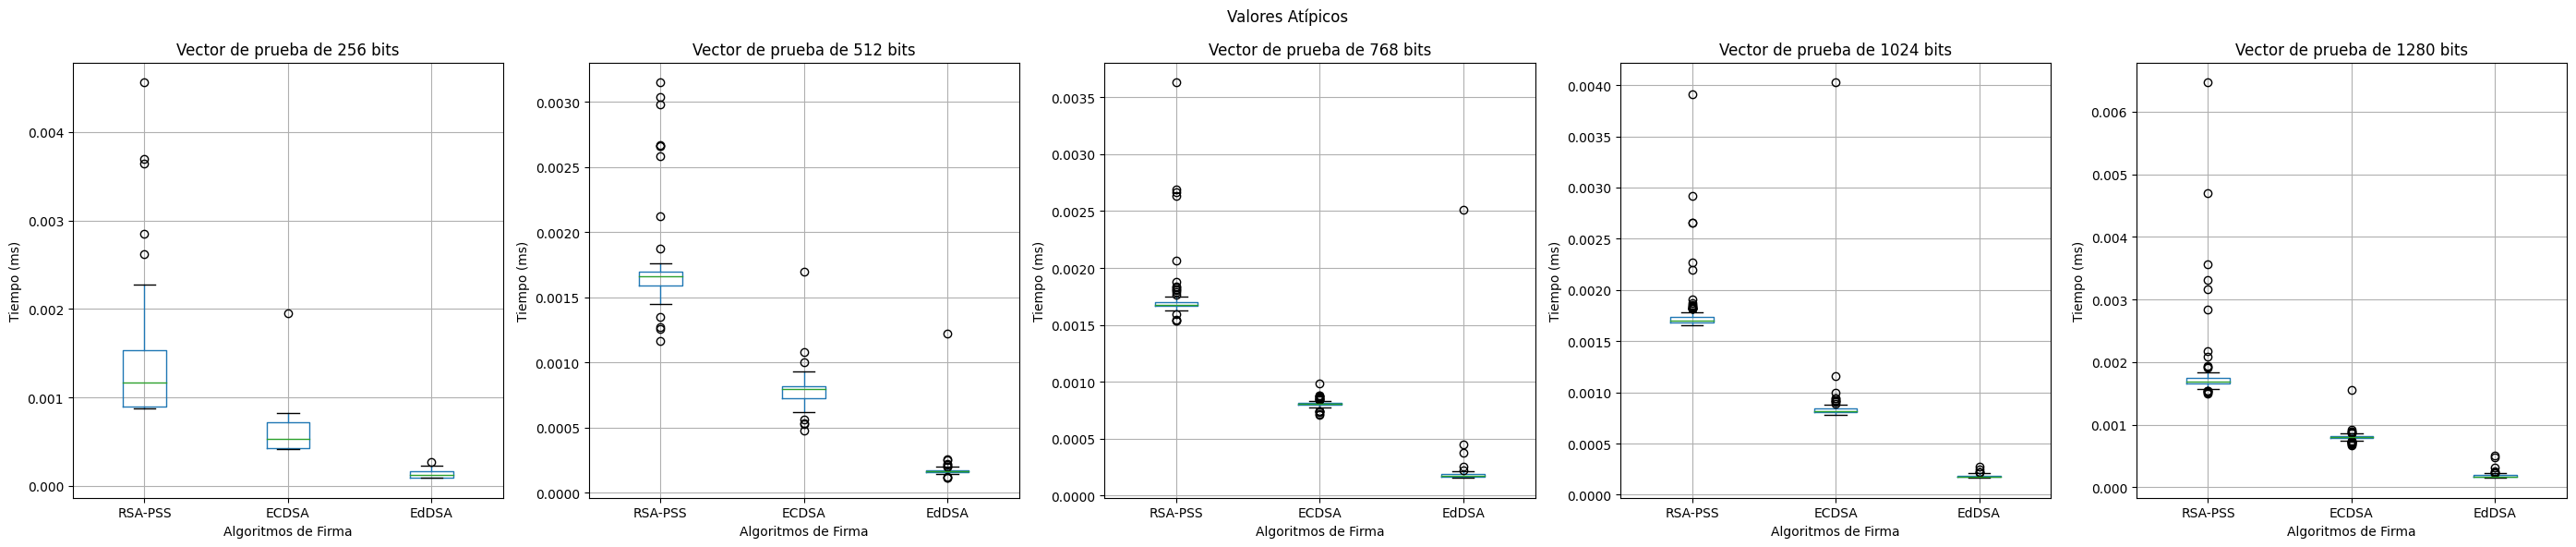

In [37]:
#Observamos los valores atípicos
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 6))

toNumeric(tiempos_firma_df, df1, 0, axs)
toNumeric(tiempos_firma_df, df2, 1, axs)
toNumeric(tiempos_firma_df, df3, 2, axs)
toNumeric(tiempos_firma_df, df4, 3, axs)
toNumeric(tiempos_firma_df, df5, 4, axs)


# Establecer los títulos de los ejes
for ax in axs.flat:
    ax.set_xlabel('Algoritmos de Firma')
    ax.set_ylabel('Tiempo (ms)')

plt.suptitle('Valores Atípicos')

# Mostrar la figura
plt.tight_layout()
plt.show()

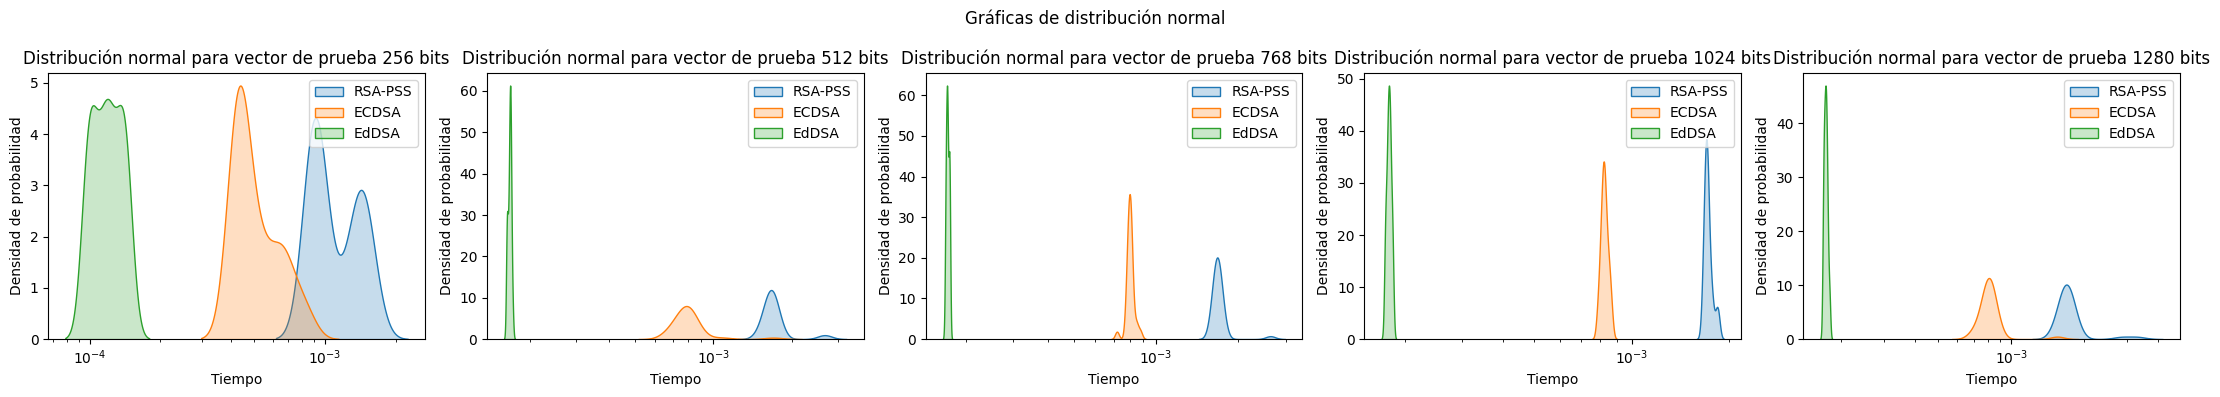

In [38]:
#Quitamos valores atípicos por columna en cada DataFrame
dfa1 = removeOutliers(df1)
dfa2 = removeOutliers(df2)
dfa3 = removeOutliers(df3)
dfa4 = removeOutliers(df4)
dfa5 = removeOutliers(df5)

#Declarar la imagen de gráficas
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))

for col in dfa1.columns:
    sns.kdeplot(dfa1[col], fill=True, log_scale=True, label=col, ax=axs[0])

axs[0].set_title('Distribución normal para vector de prueba 256 bits')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()


for col in dfa2.columns:
    sns.kdeplot(dfa2[col], fill=True, log_scale=True, label=col, ax=axs[1])

axs[1].set_title('Distribución normal para vector de prueba 512 bits')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()


for col in dfa3.columns:
    sns.kdeplot(dfa3[col], fill=True, log_scale=True, label=col, ax=axs[2])

axs[2].set_title('Distribución normal para vector de prueba 768 bits')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Densidad de probabilidad')
axs[2].legend()


for col in dfa4.columns:
    sns.kdeplot(dfa4[col], fill=True, log_scale=True, label=col, ax=axs[3])

axs[3].set_title('Distribución normal para vector de prueba 1024 bits')
axs[3].set_xlabel('Tiempo')
axs[3].set_ylabel('Densidad de probabilidad')
axs[3].legend()

for col in dfa5.columns:
    sns.kdeplot(dfa5[col], fill=True, log_scale=True, label=col, ax=axs[4])

axs[4].set_title('Distribución normal para vector de prueba 1280 bits')
axs[4].set_xlabel('Tiempo')
axs[4].set_ylabel('Densidad de probabilidad')
axs[4].legend()

plt.suptitle('Gráficas de distribución normal')

fig.tight_layout()
plt.show()

In [39]:
#Calculamos las medias y la desviación estándar
media1 = dfa1.mean()
media2 = dfa2.mean()
media3 = dfa3.mean()
media4 = dfa4.mean()
media5 = dfa5.mean()
std1 = dfa1.std()
std2 = dfa2.std()
std3 = dfa3.std()
std4 = dfa4.std()
std5 = dfa5.std()

#DataFrame de medias 256, 512, 768, 1024 y 1280
data = {'256 bits': media1,
        '512 bits': media2,
        '768 bits': media3,
        '1024 bits': media4,
        '1280 bits': media5}
Medias = pd.DataFrame(data)

#DataFrame de desviación estándar 256, 512, 768, 1024 y 1280
data = {'256 bits': std1,
        '512 bits': std2,
        '768 bits': std3,
        '1024 bits': std4,
        '1280 bits': std5}
Desviacion = pd.DataFrame(data)

#Imprimir los DataFrame de medias y desviación
print("Tabla de Medias\n")
print(Medias)
print("\n")
print("Tabla de Desviación estándar\n")
print(Desviacion)

Tabla de Medias

         256 bits  512 bits  768 bits  1024 bits  1280 bits
RSA-PSS  0.001130  0.001723  0.001712   0.001722   0.001776
ECDSA    0.000517  0.000821  0.000803   0.000824   0.000826
EdDSA    0.000119  0.000167  0.000172   0.000178   0.000172


Tabla de Desviación estándar

         256 bits  512 bits  768 bits  1024 bits  1280 bits
RSA-PSS  0.000263  0.000262  0.000175   0.000050   0.000362
ECDSA    0.000122  0.000181  0.000026   0.000021   0.000142
EdDSA    0.000017  0.000002  0.000002   0.000003   0.000003


### Temporizar verificación de firmas

In [40]:
##ALGORITMOS DE VERIFICACIÓN: RSA-PSS, ECDSA, EdDSA

tiempos_verificacion_df = pd.DataFrame(
    columns=['RSA-PSS', 'ECDSA', 'EdDSA']
)

# Agregar filas vacías al DataFrame
for i in range(500):
    tiempos_verificacion_df.loc[i] = [None, None, None]

for i in range(5):
  for j in range(100):
    iter = 100 * i + j
    RSA_PSS_time = timeit.timeit(
      lambda: RSA_PSS_public_key.verify(
        RSA_PSS_signs[i],test_vectors_RSA_PSS[i][0], RSA_PSS_padding, hashes.SHA256()),
      number=1
    )
    tiempos_verificacion_df.loc[iter, 'RSA-PSS'] = RSA_PSS_time

    ECDSA_time = timeit.timeit(
      lambda: ECDSA_public_key.verify(
        ECDSA_signs[i],test_vectors_ECDSA[i][0], ec.ECDSA(hashes.SHA512())),
      number=1
    )
    tiempos_verificacion_df.loc[iter, 'ECDSA'] = ECDSA_time

    EdDSA_time = timeit.timeit(
      lambda: EdDSA_public_key.verify(EdDSA_signs[i],test_vectors_EDDSA[i][0]),
      number=1
    )
    tiempos_verificacion_df.loc[iter, 'EdDSA'] = EdDSA_time


###Análisis estadístico descriptivo de los algoritmos de verificación

In [41]:
#Definición de Funciones
def toNumeric(dfFull, dfSplit, cont, axis):
  dfFull['RSA-PSS'] = pd.to_numeric(dfSplit['RSA-PSS'])
  dfFull['ECDSA'] = pd.to_numeric(dfSplit['ECDSA'])
  dfFull['EdDSA'] = pd.to_numeric(dfSplit['EdDSA'])
  dfFull.boxplot(ax=axis[cont])
  axis[cont].set_title('Vector de prueba de ' + str((cont+1)*256) + ' bits')

def removeOutliers(dfSplit):
  for columna in dfSplit.columns:
    Q1 = dfSplit[columna].quantile(0.30)
    Q3 = dfSplit[columna].quantile(0.60)
    dfClean = dfSplit[(dfSplit[columna] > Q1) & (dfSplit[columna] < Q3)]
  return dfClean

#Convertimos el DataFrame en un array numpy
array = tiempos_verificacion_df.to_numpy()

#Dividimos el DataFrame en 5 DataFrames por vector de prueba
dataframes = np.array_split(array, 5)
df1 = pd.DataFrame(dataframes[0], columns=tiempos_verificacion_df.columns)
df2 = pd.DataFrame(dataframes[1], columns=tiempos_verificacion_df.columns)
df3 = pd.DataFrame(dataframes[2], columns=tiempos_verificacion_df.columns)
df4 = pd.DataFrame(dataframes[3], columns=tiempos_verificacion_df.columns)
df5 = pd.DataFrame(dataframes[4], columns=tiempos_verificacion_df.columns)

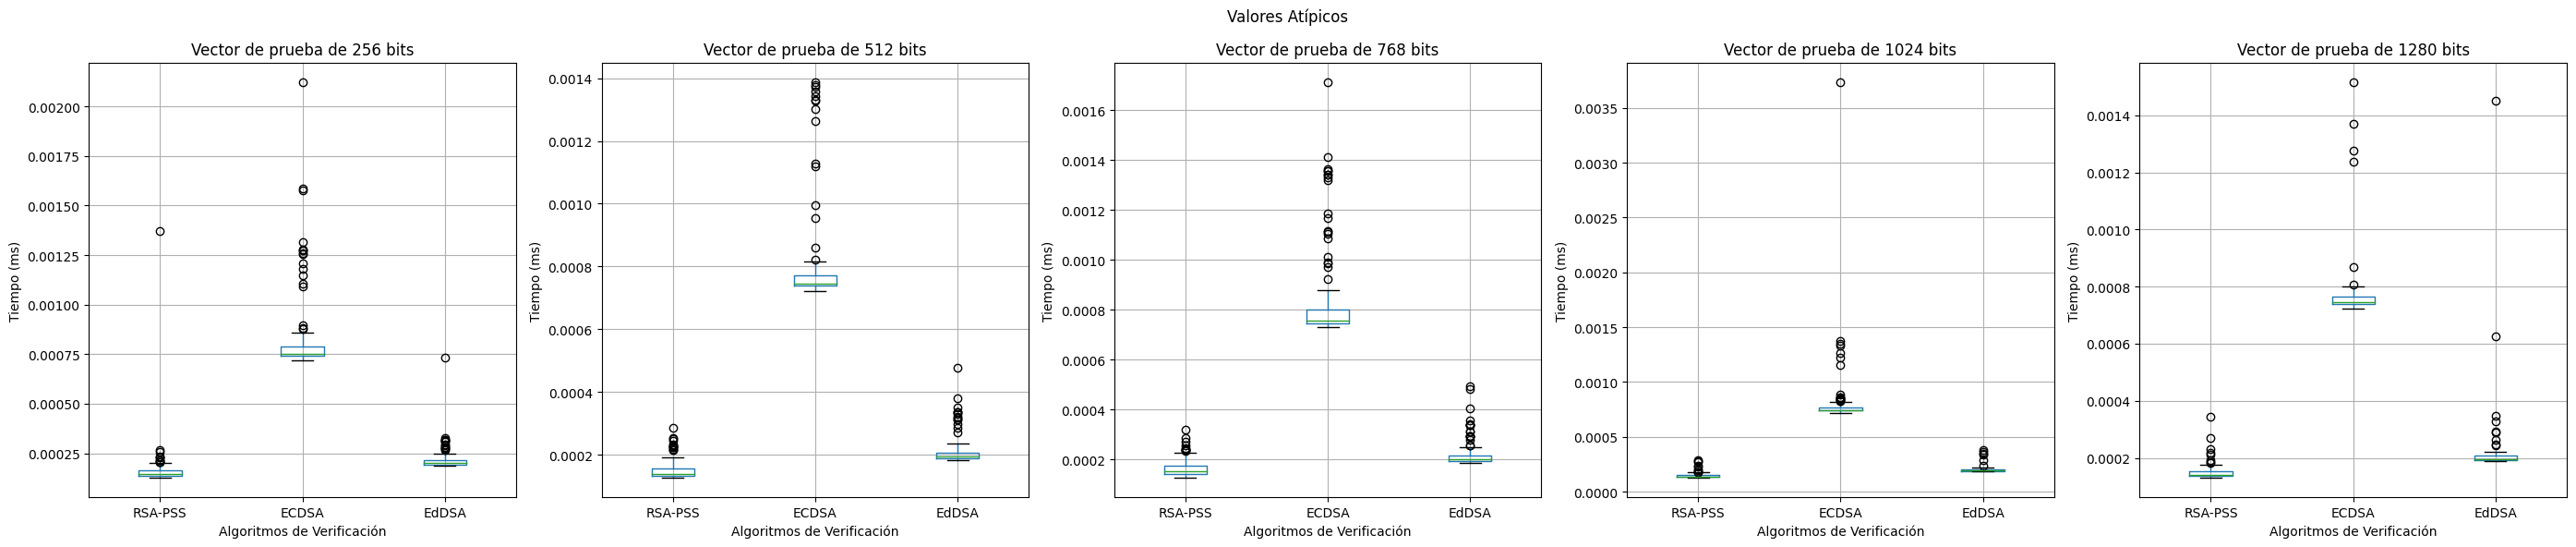

In [42]:
#Observamos los valores atípicos
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 6))

toNumeric(tiempos_verificacion_df, df1, 0, axs)
toNumeric(tiempos_verificacion_df, df2, 1, axs)
toNumeric(tiempos_verificacion_df, df3, 2, axs)
toNumeric(tiempos_verificacion_df, df4, 3, axs)
toNumeric(tiempos_verificacion_df, df5, 4, axs)


# Establecer los títulos de los ejes
for ax in axs.flat:
    ax.set_xlabel('Algoritmos de Verificación')
    ax.set_ylabel('Tiempo (ms)')

plt.suptitle('Valores Atípicos')

# Mostrar la figura
plt.tight_layout()
plt.show()

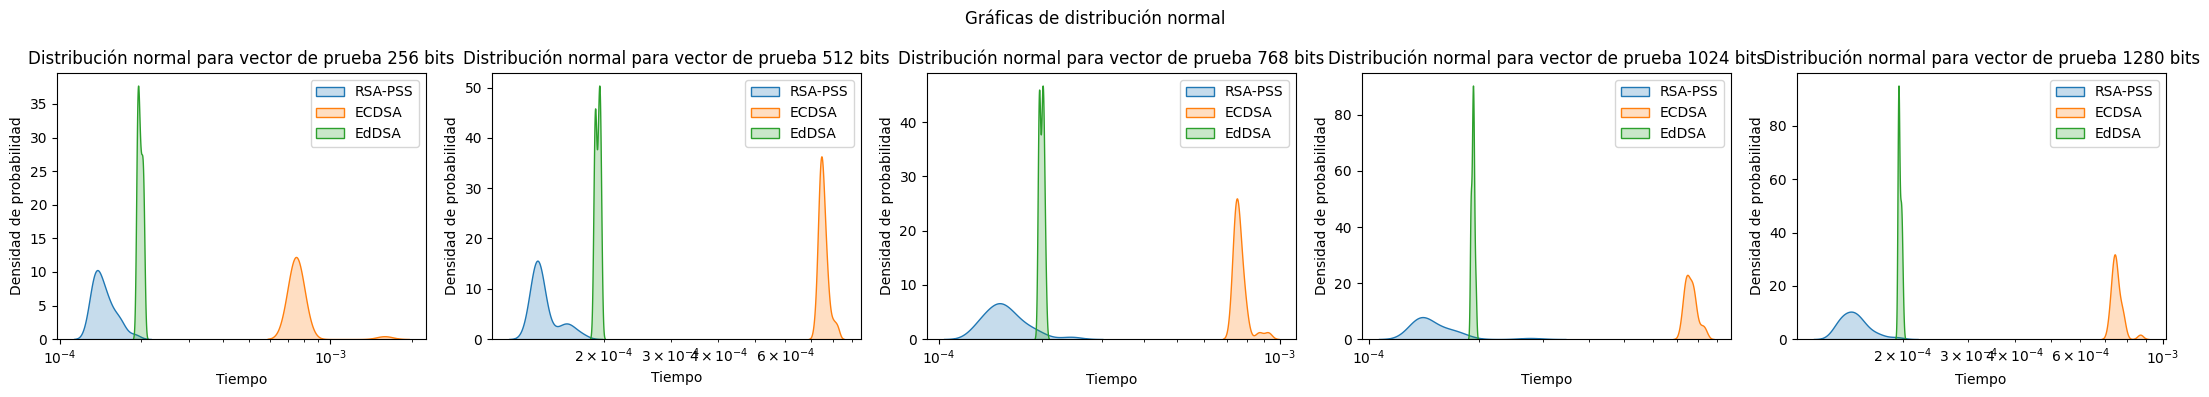

In [43]:
#Quitamos valores atípicos por columna en cada DataFrame
dfa1 = removeOutliers(df1)
dfa2 = removeOutliers(df2)
dfa3 = removeOutliers(df3)
dfa4 = removeOutliers(df4)
dfa5 = removeOutliers(df5)

#Declarar la imagen de gráficas
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))

for col in dfa1.columns:
    sns.kdeplot(dfa1[col], fill=True, log_scale=True, label=col, ax=axs[0])

axs[0].set_title('Distribución normal para vector de prueba 256 bits')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()


for col in dfa2.columns:
    sns.kdeplot(dfa2[col], fill=True, log_scale=True, label=col, ax=axs[1])

axs[1].set_title('Distribución normal para vector de prueba 512 bits')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()


for col in dfa3.columns:
    sns.kdeplot(dfa3[col], fill=True, log_scale=True, label=col, ax=axs[2])

axs[2].set_title('Distribución normal para vector de prueba 768 bits')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Densidad de probabilidad')
axs[2].legend()


for col in dfa4.columns:
    sns.kdeplot(dfa4[col], fill=True, log_scale=True, label=col, ax=axs[3])

axs[3].set_title('Distribución normal para vector de prueba 1024 bits')
axs[3].set_xlabel('Tiempo')
axs[3].set_ylabel('Densidad de probabilidad')
axs[3].legend()

for col in dfa5.columns:
    sns.kdeplot(dfa5[col], fill=True, log_scale=True, label=col, ax=axs[4])

axs[4].set_title('Distribución normal para vector de prueba 1280 bits')
axs[4].set_xlabel('Tiempo')
axs[4].set_ylabel('Densidad de probabilidad')
axs[4].legend()

plt.suptitle('Gráficas de distribución normal')

fig.tight_layout()
plt.show()

In [44]:
#Calculamos las medias y la desviación estándar
media1 = dfa1.mean()
media2 = dfa2.mean()
media3 = dfa3.mean()
media4 = dfa4.mean()
media5 = dfa5.mean()
std1 = dfa1.std()
std2 = dfa2.std()
std3 = dfa3.std()
std4 = dfa4.std()
std5 = dfa5.std()

#DataFrame de medias 256, 512, 768, 1024 y 1280
data = {'256 bits': media1,
        '512 bits': media2,
        '768 bits': media3,
        '1024 bits': media4,
        '1280 bits': media5}
Medias = pd.DataFrame(data)

#DataFrame de desviación estándar 256, 512, 768, 1024 y 1280
data = {'256 bits': std1,
        '512 bits': std2,
        '768 bits': std3,
        '1024 bits': std4,
        '1280 bits': std5}
Desviacion = pd.DataFrame(data)

#Imprimir los DataFrame de medias y desviación
print("Tabla de Medias\n")
print(Medias)
print("\n")
print("Tabla de Desviación estándar\n")
print(Desviacion)

Tabla de Medias

         256 bits  512 bits  768 bits  1024 bits  1280 bits
RSA-PSS  0.000146  0.000140  0.000158   0.000152   0.000149
ECDSA    0.000775  0.000754  0.000764   0.000762   0.000752
EdDSA    0.000198  0.000193  0.000200   0.000192   0.000196


Tabla de Desviación estándar

         256 bits  512 bits  768 bits  1024 bits  1280 bits
RSA-PSS  0.000014  0.000012  0.000024   0.000028   0.000014
ECDSA    0.000154  0.000022  0.000040   0.000029   0.000028
EdDSA    0.000004  0.000003  0.000003   0.000002   0.000002
